In [33]:
#import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pylab as pl
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import MiniBatchKMeans
from preprocess import *
import joblib
from collections import Counter
import cv2
import seaborn as sb
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing &  Sift Features

In [3]:
A = load_Dataset("../fonts-dataset/Scheherazade New/*.jpeg")
B= load_Dataset("../fonts-dataset/Lemonada/*.jpeg")
C= load_Dataset("../fonts-dataset/Marhey/*.jpeg")
D= load_Dataset("../fonts-dataset/IBM Plex Sans Arabic/*.jpeg")

800
800
800
800


In [4]:
A, A_TEST = train_test_split(A, test_size=0.2)
B, B_TEST = train_test_split(B, test_size=0.2)
C, C_TEST = train_test_split(C, test_size=0.2)
D, D_TEST = train_test_split(D, test_size=0.2)

In [5]:
A_PROCESSED = []
for img in A:
    img=denoise(img)
    A_PROCESSED.append(img)
print("A: ", len(A_PROCESSED))
B_PROCESSED = []
for img in B:
    img=denoise(img)
    B_PROCESSED.append(img)
print("B: ", len(B_PROCESSED))
C_PROCESSED = []
for img in C:
    img=denoise(img)
    C_PROCESSED.append(img)
print("C: ", len(C_PROCESSED))
D_PROCESSED = []
for img in D:
    img=denoise(img)
    D_PROCESSED.append(img)
print("D: ", len(D_PROCESSED))

A:  640
B:  640
C:  640
D:  640


In [6]:
def extract_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors

In [7]:
def prepare_data(images):
    features = []
    for image in images:
        descriptors = extract_sift_features(image)
        if descriptors  is not None:
            features.append(descriptors)
    return features

In [8]:
def create_codebook(features, num_clusters, batch_size):
    # Create a MiniBatchKMeans clustering object
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, batch_size=batch_size, random_state=0)

    # Fit the clustering model to the SIFT features
    kmeans.fit(features)

    return kmeans

In [9]:
def compute_bovw_representation(features, codebook):
    num_clusters = codebook.n_clusters
    bovw_representation = []

    for image_features in features:
        if len(image_features) > 0:
            # Assign each feature to a cluster
            image_features=image_features.reshape(-1,128)
            cluster_assignments = codebook.predict(image_features)

            # Create a histogram of cluster frequencies
            histogram = np.bincount(cluster_assignments, minlength=num_clusters)

            # Normalize the histogram
            histogram = histogram / np.sum(histogram)

            bovw_representation.append(histogram)
        else:
            # Handle cases where no features were detected
            bovw_representation.append(np.zeros(num_clusters))

    return bovw_representation

In [10]:
A_PROCESSED= prepare_data(A_PROCESSED)
B_PROCESSED= prepare_data(B_PROCESSED)
C_PROCESSED= prepare_data(C_PROCESSED)
D_PROCESSED= prepare_data(D_PROCESSED)

In [11]:
train_labels= np.array([0]*len(A_PROCESSED) + [1]*len(B_PROCESSED) + [2]*len(C_PROCESSED) + [3]*len(D_PROCESSED))

In [12]:
print("A: ", A_PROCESSED[0].shape)
print("B: ", B_PROCESSED[0].shape)
print("C: ", C_PROCESSED[0].shape)
print("D: ", D_PROCESSED[0].shape)

A:  (4282, 128)
B:  (2397, 128)
C:  (2143, 128)
D:  (2003, 128)


In [13]:
A.clear()
B.clear()
C.clear()
D.clear()

In [14]:
combined_list = A_PROCESSED + B_PROCESSED + C_PROCESSED + D_PROCESSED
concatenated_train_sift_features = np.vstack(combined_list)
print(concatenated_train_sift_features.shape)

(6763165, 128)


In [15]:
print(len(combined_list))
print(len(train_labels))

2558
2558


In [16]:
A_PROCESSED.clear()
B_PROCESSED.clear()
C_PROCESSED.clear()
D_PROCESSED.clear()

## Kmeans Clustering for bag of words creation

In [17]:
num_clusters=100
batch_size=1000
codebook = create_codebook(concatenated_train_sift_features, 100, 1000)
print(codebook)

MiniBatchKMeans(batch_size=1000, n_clusters=100, random_state=0)


In [18]:
joblib.dump(codebook, 'codebook.pkl')

['codebook.pkl']

In [19]:
train_bovw_features = compute_bovw_representation(combined_list, codebook)

In [20]:
A_TPROCESSED = []
for img in A_TEST:
    img=denoise(img)
    A_TPROCESSED.append(img)
print("A: ", len(A_TPROCESSED))
B_TPROCESSED = []
for img in B_TEST:
    img=denoise(img)
    B_TPROCESSED.append(img)
print("B: ", len(B_TPROCESSED))
C_TPROCESSED = []
for img in C_TEST:
    img=denoise(img)
    C_TPROCESSED.append(img)
print("C: ", len(C_TPROCESSED))
D_TPROCESSED = []
for img in D_TEST:
    img=denoise(img)
    D_TPROCESSED.append(img)
print("D: ", len(D_TPROCESSED))
 

A:  160
B:  160
C:  160
D:  160


In [21]:

A_TEST.clear()
B_TEST.clear()
C_TEST.clear()
D_TEST.clear()

In [22]:
A_TPROCESSED= prepare_data(A_TPROCESSED)
B_TPROCESSED= prepare_data(B_TPROCESSED)
C_TPROCESSED= prepare_data(C_TPROCESSED)
D_TPROCESSED= prepare_data(D_TPROCESSED)

In [23]:
combined_test=A_TPROCESSED+B_TPROCESSED+C_TPROCESSED+D_TPROCESSED
print(len(combined_test))
test_bovw_features=compute_bovw_representation(combined_test,codebook)

639


In [24]:
test_labels= np.array([0]*len(A_TPROCESSED) + [1]*len(B_TPROCESSED) + [2]*len(C_TPROCESSED) + [3]*len(D_TPROCESSED))

In [25]:
A_TPROCESSED.clear()
B_TPROCESSED.clear()
C_TPROCESSED.clear()
D_TPROCESSED.clear()

## Grid Searching for the best svm model features

In [26]:
params_grid = [{'C': [0.1,1, 10], 'gamma': [0.01, 0.1,1], 'kernel': ['rbf']}]
gridSearch= GridSearchCV(SVC(), params_grid, cv=5,verbose=10, n_jobs=-1)

In [27]:
print(len(train_bovw_features))
print(len(train_labels))

2558
2558


In [28]:
gridSearch.fit(train_bovw_features, train_labels)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1],
                          'kernel': ['rbf']}],
             verbose=10)

In [29]:
y_pred = gridSearch.predict(train_bovw_features)
print("Accuracy: ", accuracy_score(train_labels, y_pred))

Accuracy:  0.9718530101641908


In [30]:
print(len(test_bovw_features))

639


In [31]:
y_pred = gridSearch.predict(test_bovw_features)
print("Accuracy: ", accuracy_score(test_labels, y_pred))

Accuracy:  0.9702660406885759


In [32]:
joblib.dump(gridSearch, 'model.pkl')

['model.pkl']

# Model Accuracy Metrics

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
class_names = ['Scheherazade New', 'Lemonada', 'Marhey', 'IBM Plex Sans Arabic']
print(classification_report(test_labels, y_pred, target_names=class_names))
accuracy = np.mean(test_labels == y_pred)
print(f"\nTotal Accuracy: {accuracy*100:.4f}")

                      precision    recall  f1-score   support

    Scheherazade New       0.96      0.96      0.96       160
            Lemonada       0.99      1.00      1.00       159
              Marhey       0.93      0.97      0.95       160
IBM Plex Sans Arabic       0.99      0.95      0.97       160

            accuracy                           0.97       639
           macro avg       0.97      0.97      0.97       639
        weighted avg       0.97      0.97      0.97       639


Total Accuracy: 97.0266



Per-Class Accuracy:
                      Accuracy
Scheherazade New      0.962500
Lemonada              0.993750
Marhey                0.933735
IBM Plex Sans Arabic  0.993464


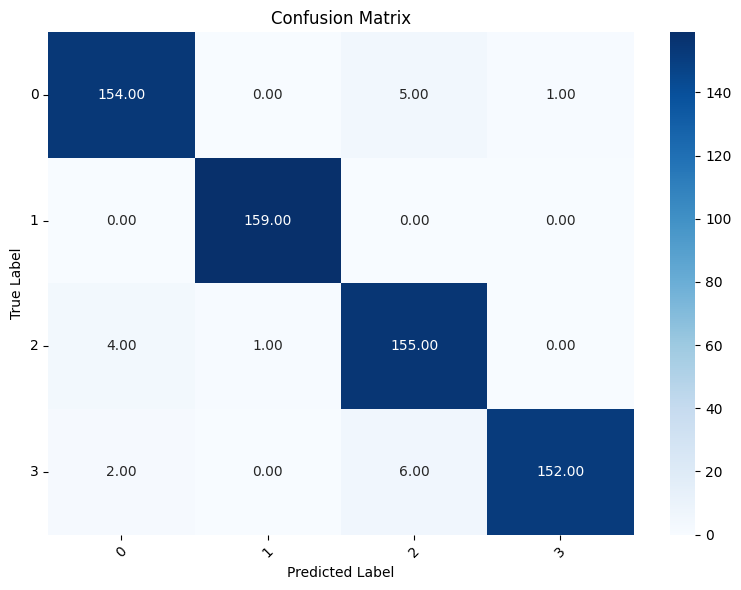

In [46]:
if class_names is not None:
    per_class_accuracy = np.diag(confusion_matrix(test_labels, y_pred)) / np.sum(confusion_matrix(test_labels, y_pred), axis=0)
    print(f"\nPer-Class Accuracy:\n{pd.DataFrame(per_class_accuracy, index=class_names, columns=['Accuracy'])}")

    # Create and visualize confusion matrix
    cm = confusion_matrix(test_labels, y_pred)
    plt.figure(figsize=(8, 6))
    sb.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
